In [1]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import sys, os   
# import utils

outdir            = os.path.join("/cbscratch/franco/", "tejaas_output/validation")
tejaas_outdir     = os.path.join("/cbscratch/franco/", "tejaas_output/output")
tejaas_outdir_rakt= os.path.join("/cbscratch/franco/", "raktim_data/crop_tejaas_out")

# MatrixEQTL_outdir = os.path.join("/cbscratch/franco/", "tejaas_output/matrixEQTL_out")
MatrixEQTL_outdir = os.path.join("/cbscratch/franco/", "tejaas_output/matrixEQTL_out_filteredGT")
gtex_out_dir      = "gtex_results"
cardio_out_dir    = "cardio_results"
chroms_file       = "devtools/chroms.txt"


chroms_file = "chroms.txt"
with open(chroms_file) as instream:
    chr_list = [int(line.strip())for line in instream if len(line.strip()) > 0]      

In [2]:
import mpmath
import numpy as np
import os 
import random
import operator

# decimal places
mpmath.mp.dps = 500
def pval(x): return mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2))))

def load_tejaas_jpa_results(chr_list, input_dir):
    tejaas_dict = dict()
    for chrm in chr_list:
        print( "Reading TEJAAS chr{:d}".format(chrm))
        dirc = os.path.join(input_dir, "chr{:d}".format(chrm))
        pths = [os.path.join(dirc,path) for path in os.listdir(dirc) if "_jpa.txt" in path]
        for pth in pths:
            pvals= list()
            l = open(str(pth),"r").readlines()
            for line in l[1:]:    
                arr      = line.strip().split("\t")
                rsid     = arr[0]
                jpascore = float(arr[1])
                tejaas_dict[rsid] = jpascore
    return tejaas_dict

def load_tejaas_results(chr_list, input_dir):
    tejaas_dict = dict()
    for chrm in chr_list:
        print( "Reading TEJAAS chr{:d}".format(chrm))
        dirc = os.path.join(input_dir, "chr{:d}".format(chrm))
        pths = [os.path.join(dirc,path) for path in os.listdir(dirc) if "_rr.txt" in path]
        for pth in pths:
            pvals= list()
            l = open(str(pth),"r").readlines()
            for line in l[1:]:    
                arr   = line.strip().split("\t")
                rsid  = arr[0]
                P     = float(arr[5])
                Q     = float(arr[2])
                Mu    = float(arr[3])
                Sigma = float(arr[4])
                pvalue= np.log10(P) if P!=0 else pval((Q-Mu)/Sigma)
                tejaas_dict[rsid] = pvalue 
    return tejaas_dict

def load_tejaas_results_orig(chr_list, gtex_dir, cardio_dir):
    gtex_dict = dict()
    cardio_dict = dict()
    for chrm in chr_list:
        print( "Reading TEJAAS chr{:d}".format(chrm))
        dirc = os.path.join(gtex_dir, "chr{:d}".format(chrm))
        pths = [os.path.join(dirc,path) for path in os.listdir(dirc) if "_rr.txt" in path]
        for pth in pths:
            pvals= list()
            l = open(str(pth),"r").readlines()
            rsids = [line.split("\t")[0] for line in l[1:]]
            for line in l[1:]:    
                P     = float(line.split("\t")[5])
                Q     = float(line.split("\t")[2])
                Mu    = float(line.split("\t")[3])
                Sigma = float(line.split("\t")[4])
                pvals.append(np.log10(P) if P!=0 else pval((Q-Mu)/Sigma))
            for i in range(len(rsids)):
                gtex_dict[rsids[i]] = pvals[i]

        dirc = os.path.join(cardio_dir, "chr{:d}".format(chrm))
        pths = [os.path.join(dirc,path) for path in os.listdir(dirc) if "_rr.txt" in path]
        for pth in pths:
            pvals = list()
            l = open(str(pth),"r").readlines()
            rsids = [line.split("\t")[0] for line in l[1:]]
            for line in l[1:]:
                P     = float(line.split("\t")[5])
                Q     = float(line.split("\t")[2])
                Mu    = float(line.split("\t")[3])
                Sigma = float(line.split("\t")[4])
                pvals.append(np.log10(P) if P!=0 else pval((Q-Mu)/Sigma))
            for i in range(len(rsids)):
                cardio_dict[rsids[i]] = pvals[i]
    return gtex_dict, cardio_dict


def load_matrixeqtl_results(chr_list, input_file):
    matrix_dict = {}
    for chrm in chr_list:
        print( "Reading matrixEQTL chr{:d}".format(chrm))
        results_file = os.path.join(input_file.format(chrm))
        with open(results_file) as instream:
            _ = instream.readline()
            for line in instream:
                arr  = line.rstrip().split("\t")
                rsid = arr[0]
                FDR  = float(arr[5])
                if rsid not in matrix_dict:
                    matrix_dict[rsid] = np.log10(FDR)
    return matrix_dict

def load_matrixeqtl_results_old(chr_list, gtex_dir, cardio_dir):
    gtex_matrix_dict = {}
    cardio_matrix_dict = {}
    for chrm in chr_list:
        print( "Reading matrixEQTL chr{:d}".format(chrm))
        results_file = os.path.join(gtex_dir, "gtex_MatrixEQTL_chr{:d}.transout".format(chrm))
        with open(results_file) as instream:
            _ = instream.readline()
            for line in instream:
                arr  = line.rstrip().split("\t")
                rsid = arr[0]
                FDR  = float(arr[5])
                if rsid not in gtex_matrix_dict:
                    gtex_matrix_dict[rsid] = np.log10(FDR)
        
        results_file = os.path.join(cardio_dir, "cardiogenics_MatrixEQTL_chr{:d}.transout".format(chrm))
        with open(results_file) as instream:
            _ = instream.readline()
            for line in instream:
                arr  = line.rstrip().split("\t")
                rsid = arr[0]
                FDR  = float(arr[5])
                if rsid not in cardio_matrix_dict:
                    cardio_matrix_dict[rsid] = np.log10(FDR)
    return gtex_matrix_dict, cardio_matrix_dict

In [29]:
def get_compatible_snp_dicts(dict1, dict2):
    k1  = list(dict1.keys())
    k2  = list(dict2.keys())

    ndict1 = copy.deepcopy(dict1)  # takes ~ 1.21 s
    ndict2 = copy.deepcopy(dict2)    

    # see if snps in test_dict are in validated_dict
    for k in k1:
        val2 = ndict2.get(k, None) 
        if val2 == None:
            del ndict1[k]

    for k in k2:
        val1 = ndict1.get(k, None) 
        if val1 == None:
            del ndict2[k]

#     print(len(list(dict1.keys())))
#     print(len(list(dict2.keys())))
    return ndict1, ndict2

def get_replication_sizes(test_dict, validation_dict, title, pval_thres=np.log10(0.05)):        
#     pval_thres = np.log10(0.05)
    
    rsids1  = list(test_dict.keys())
    rsids2  = list(validation_dict.keys())

    n_snps1 = len(rsids1)
    n_snps2 = len(rsids2)

#     common_snps = [snp for snp in rsids1 if validation_dict.get(snp, None) != None ]
    compat_test_dict, compat_validation_dict = get_compatible_snp_dicts(test_dict, validation_dict)
    compat_rsids = list(compat_test_dict.keys())
    common_n_snps = len(compat_rsids)

    signif_snps1 = [snp for snp in rsids1 if test_dict[snp] < pval_thres]
    signif_snps2 = [snp for snp in rsids2 if validation_dict[snp] < pval_thres]

    nsig1 = len(signif_snps1)
    nsig2 = len(signif_snps2)
    
    compat_signig_snps1 = [snp for snp in compat_rsids if compat_test_dict[snp] < pval_thres]
    compat_signig_snps2 = [snp for snp in compat_rsids if compat_validation_dict[snp] < pval_thres]

    common_signif_snps = [snp for snp in signif_snps1 if snp in signif_snps2]

    print("Algorithm      |Nº snps1|Nº snps2| common |  %   |Nº sig1 |Nº sig2 |NºC sig1|NºC sig2| common |   %  ")

    if n_snps1 > 0 and n_snps2 > 0:
        int_ratio = 100*common_n_snps/min(n_snps1, n_snps2)
    else:
        int_ratio = 0
    if nsig1 > 0 and nsig2 > 0:
        sig_ratio = 100*len(common_signif_snps)/min(nsig1, nsig2)
    else:
        sig_ratio = 0
    print("{:15s}|{:8d}|{:8d}|{:8d}|{:6.2f}|{:8d}|{:8d}|{:8d}|{:8d}|{:8d}|{:6.2f}".format(title, n_snps1,\
        n_snps2, common_n_snps, int_ratio, nsig1, nsig2, \
        len(compat_signig_snps1), len(compat_signig_snps2), \
        len(common_signif_snps), sig_ratio))

def get_validation_curve_jpa(test_dict, validation_dict, thres=20, randomize=False):    
    n_snps = len(validation_dict.keys())
    isReversed = True # descending order
    validation_tuples = sorted(validation_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    validation_rsids = [validation_tuples[i][0] for i in range(n_snps)]
    validation_pvals = [validation_tuples[i][1] for i in range(n_snps)]

    # test_pvals = [test_dict[e] for e in test_dict.keys()]
    
    # print(np.min(validation_pvals), np.max(validation_pvals))
    # print(np.min(test_pvals), np.max(test_pvals))
    if randomize:
        random.shuffle(validation_rsids)
    
    toplot = []
    check_x = []
    positives = []
        
    i = 0 
    while(i < n_snps):
        try:
            if(test_dict[validation_rsids[i]] > thres):
                positives.append(i)
        except:
            pass
        i = i + 1
        while(i < n_snps and validation_pvals[i] == validation_pvals[i-1]):
            try:
                if(test_dict[validation_rsids[i]] > thres):
                    positives.append(i)
            except:
                pass
            i = i + 1
        check_x.append(i)
        toplot.append(len(positives))
    return check_x, toplot
    
def get_validation_curve(test_dict, validation_dict, pval_thres=0.05, islog=True, randomize=False):    
    n_snps = len(validation_dict.keys())
    isReversed = True
    if islog:
        isReversed = False
    validation_tuples = sorted(validation_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    validation_rsids = [validation_tuples[i][0] for i in range(n_snps)]
    validation_pvals = [validation_tuples[i][1] for i in range(n_snps)]

    # test_pvals = [test_dict[e] for e in test_dict.keys()]
    
    # print(np.min(validation_pvals), np.max(validation_pvals))
    # print(np.min(test_pvals), np.max(test_pvals))
    if randomize:
        random.shuffle(validation_rsids)
    
    toplot = []
    check_x = []
    positives = []
    if islog:
        pval_thres = np.log10(pval_thres)
        
    i = 0 
    while(i < n_snps):
        try:
            if(test_dict[validation_rsids[i]] < pval_thres):
                positives.append(i)
        except:
            pass
        i = i + 1
        while(i < n_snps and validation_pvals[i] == validation_pvals[i-1]):
            try:
                if(test_dict[validation_rsids[i]] < pval_thres):
                    positives.append(i)
            except:
                pass
            i = i + 1
        check_x.append(i)
        toplot.append(len(positives))
    return check_x, toplot
        




In [12]:
# Load all results
gtex_beta   = 0.02 # 0.001  # 0.02 #
cardio_beta = 0.006 # 0.001  # 0.006 #

method = "rr"
if method == "rr":
    gtex_dir    = os.path.join(tejaas_outdir, gtex_out_dir, method,  "beta_{:n}".format(gtex_beta))
    cardio_dir  = os.path.join(tejaas_outdir, cardio_out_dir, method, "beta_{:n}".format(cardio_beta))
    tejaas_gtex_dict = load_tejaas_results(chr_list, gtex_dir)
    tejaas_cardio_dict = load_tejaas_results(chr_list, cardio_dir)
if method == "jpa":
    gtex_dir    = os.path.join(tejaas_outdir, gtex_out_dir, method,  "beta_{:n}".format(gtex_beta))
    cardio_dir  = os.path.join(tejaas_outdir, cardio_out_dir, method, "beta_{:n}".format(cardio_beta))
    tejaas_gtex_dict = load_tejaas_jpa_results(chr_list, gtex_dir)
    tejaas_cardio_dict = load_tejaas_jpa_results(chr_list, cardio_dir)

# gtex_dir   = os.path.join(MatrixEQTL_outdir, gtex_out_dir)
# cardio_dir = os.path.join(MatrixEQTL_outdir, cardio_out_dir) 
# mqtl_gtex_dict, mqtl_cardio_dict = load_matrixeqtl_results(chr_list, gtex_dir, cardio_dir)

gtex_file   = os.path.join(MatrixEQTL_outdir, gtex_out_dir, "gtex_MatrixEQTL_chr{:d}.transout")
cardio_file = os.path.join(MatrixEQTL_outdir, cardio_out_dir, "cardiogenics_MatrixEQTL_chr{:d}.transout") 
gtex_file = gtex_file + ".truetrans.afterfix"
cardio_file = cardio_file + ".truetrans.afterfix"
mqtl_gtex_dict = load_matrixeqtl_results(chr_list, gtex_file)
mqtl_cardio_dict = load_matrixeqtl_results(chr_list, cardio_file)

Reading TEJAAS chr6
Reading TEJAAS chr6
Reading matrixEQTL chr6
Reading matrixEQTL chr6


/cbscratch/franco/tejaas_output/validation/chr6_cardio_gtex_trans_comparison.png


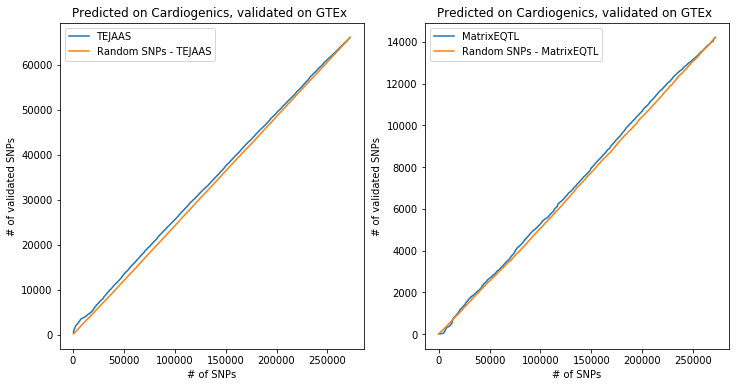

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, os   

algorithms = ["TEJAAS","MatrixEQTL"]
n_algorithms = len(algorithms)
if n_algorithms == 1:
    subplotgrid = 111
    fsize       = (6,6)
if n_algorithms == 2:
    subplotgrid = 121
    fsize       = (12,6)
if n_algorithms == 3:
    subplotgrid = 131
    fsize       = (18,6)
if n_algorithms == 3:
    subplotgrid = 221
    fsize       = (15,15)
    
fig = plt.figure(figsize = fsize)
k = 0
m = 10000
offset = 10000
    
for algo_i in range(n_algorithms):
    algorithm  = algorithms[algo_i]
    subplotgrid += algo_i

    if algorithm == "TEJAAS":
        if method == "rr":
            x_values, toplot = get_validation_curve(tejaas_gtex_dict, tejaas_cardio_dict, pval_thres=0.05)
            x_values_random, random_toplot = get_validation_curve(tejaas_gtex_dict, tejaas_cardio_dict, pval_thres=0.05, randomize=True)
        
        if method == "jpa":
            x_values, toplot = get_validation_curve_jpa(tejaas_gtex_dict, tejaas_cardio_dict)
            x_values_random, random_toplot = get_validation_curve_jpa(tejaas_gtex_dict, tejaas_cardio_dict, randomize=True)
        
    if algorithm == "MatrixEQTL":
        x_values, toplot = get_validation_curve(mqtl_gtex_dict, mqtl_cardio_dict, pval_thres=0.05)
        x_values_random, random_toplot = get_validation_curve(mqtl_gtex_dict, mqtl_cardio_dict, pval_thres=0.05, randomize=True)
        
    ax = fig.add_subplot(subplotgrid)
    plt.title('Predicted on Cardiogenics, validated on GTEx ')
    ax.plot(x_values,toplot, label=algorithm)
    ax.plot(x_values_random, random_toplot, label='Random SNPs - '+algorithm)
    ax.legend()
    ax.set_xlabel("# of SNPs")
    ax.set_ylabel("# of validated SNPs")

if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_file = os.path.join(outdir, "chr"+str(chr_list[0])+"_cardio_gtex_trans_comparison.png")
print(fig_file)
# plt.savefig(fig_file)
plt.show()

In [21]:
import copy

def get_roc_curve_reverse(statistic, label):
    x_vals = []
    i_vals = []
    n_vals = []
    recall = []
    ppv    = []
    total_TP = np.sum(label)
    
    TP = 0
    FP = 0
    n  = 0

    if label[0]:
        TP += 1
    else:
        FP += 1

    x_vals.append(statistic[0])
    i_vals.append(0)
    n_vals.append(n)
    recall.append(TP/total_TP)
    ppv.append(TP/(TP+FP))
    
    for i in range(1, len(statistic)):
        if statistic[i] < statistic[i-1]:
            n += 1
            x_vals.append(statistic[i])
            n_vals.append(n)
            i_vals.append(i)
            recall.append(TP/total_TP)
            ppv.append(TP/(TP+FP))

        if label[i]:
            TP += 1
        else:
            FP += 1
    return x_vals, i_vals, n_vals, recall, ppv

def get_roc_curve(statistic, label):
    x_vals = []
    i_vals = []
    n_vals = []
    recall = []
    ppv    = []
    total_TP = np.sum(label)
    
    TP = 0
    FP = 0
    n  = 0

    if label[0]:
        TP += 1
    else:
        FP += 1

    x_vals.append(statistic[0])
    i_vals.append(0)
    n_vals.append(n)
    recall.append(TP/total_TP)
    ppv.append(TP/(TP+FP))
    
    for i in range(1, len(statistic)):
        if statistic[i] > statistic[i-1]:
            n += 1
            x_vals.append(statistic[i])
            n_vals.append(n)
            i_vals.append(i)
            recall.append(TP/total_TP)
            ppv.append(TP/(TP+FP))

        if label[i]:
            TP += 1
        else:
            FP += 1
    return x_vals, i_vals, n_vals, recall, ppv

def evaluate_replication_jpa(test_dict, validation_dict, randomize=False, thres = 20):
    isReversed = True  

    v_keys = list(validation_dict.keys())
    n_snps = len(v_keys)

    label_dict = dict()
    for k in v_keys:
        label_dict[k] = True if validation_dict[k] >= thres else False

    test_tuples = sorted(test_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    test_rsids = [test_tuples[i][0] for i in range(n_snps)]
    test_pvals = [test_tuples[i][1] for i in range(n_snps)]
    
    if randomize:
        random.shuffle(test_rsids)
        print("Randomized")
    
    # sort labels by pvalue in test set (rsids are already sorted by pval)
    label = [label_dict[snp] for snp in test_rsids]
    x_vals, i_vals, n_vals, recall, ppv = get_roc_curve_reverse(test_pvals, label)
    
    return x_vals, i_vals, n_vals, recall, ppv

def evaluate_replication(test_dict, validation_dict, islog=True, randomize=False, pval_thres = 0.05):
    isReversed = True

    if islog:
        isReversed = False
        pval_thres = np.log10(pval_thres)
    

    v_keys = list(validation_dict.keys())
    n_snps = len(v_keys)

    label_dict = dict()
    for k in v_keys:
        label_dict[k] = True if validation_dict[k] <= pval_thres else False

    test_tuples = sorted(test_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    test_rsids = [test_tuples[i][0] for i in range(n_snps)]
    test_pvals = [test_tuples[i][1] for i in range(n_snps)]
    
    if randomize:
        random.shuffle(test_rsids)
        print("Randomized")
    
    # sort labels by pvalue in test set (rsids are already sorted by pval)
    label = [label_dict[snp] for snp in test_rsids]
    x_vals, i_vals, n_vals, recall, ppv = get_roc_curve(test_pvals, label)
    
    return x_vals, i_vals, n_vals, recall, ppv



In [22]:
def evaluate_replication_empirical(test_dict, validation_dict, islog=True, randomize=False, pval_thres = 0.05):
    isReversed = True

    if islog:
        isReversed = False


    v_keys = list(validation_dict.keys())
    n_snps = len(v_keys)

    validation_tuples = sorted(validation_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    validation_rsids = [validation_tuples[i][0] for i in range(n_snps)]
    validation_pvals = [validation_tuples[i][1] for i in range(n_snps)]

    empirical005 = np.round(n_snps/20)
    label_dict = dict()
    for i, k in enumerate(validation_rsids):
        label_dict[k] = True if i < empirical005 else False

    test_tuples = sorted(test_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    test_rsids = [test_tuples[i][0] for i in range(n_snps)]
    test_pvals = [test_tuples[i][1] for i in range(n_snps)]

    if randomize:
        random.shuffle(test_rsids)
        print("Randomized")

    # sort labels by pvalue in test set (rsids are already sorted by pval)
    label = [label_dict[snp] for snp in test_rsids]
    x_vals, i_vals, n_vals, recall, ppv = get_roc_curve(test_pvals, label)

    return x_vals, i_vals, n_vals, recall, ppv

In [23]:
def get_ranks(my_dict, islog=True, randomize=False):
    # isReversed = True
    # randomize = False
    # # pval_thres = 0.05
    # islog = True

    if islog:
        isReversed = False

    my_keys = list(my_dict.keys())
    n_snps = len(my_keys)

    tuples = sorted(my_dict.items(), key=operator.itemgetter(1),reverse=isReversed)
    rsids = [tuples[i][0] for i in range(n_snps)]
    pvals = [tuples[i][1] for i in range(n_snps)]

    if randomize:
        random.shuffle(rsids)
        print("Randomized")

    x_rank_dict = dict()
    for i, k in enumerate(rsids):
        x_rank_dict[k] = i
    return x_rank_dict

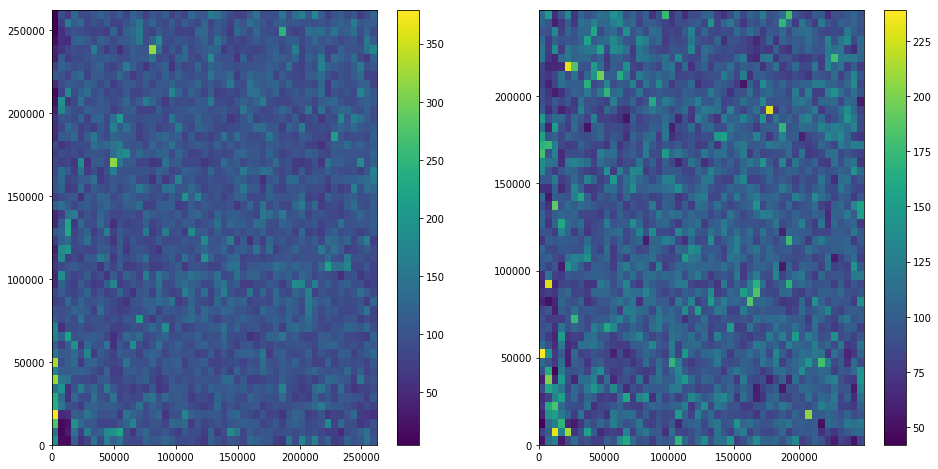

In [24]:
validation_dict, test_dict = get_compatible_snp_dicts(tejaas_gtex_dict, tejaas_cardio_dict)

validation_rank = get_ranks(validation_dict)
test_rank = get_ranks(test_dict)

allrsids = list(test_rank.keys())
xpoints = [test_rank[k] for k in allrsids]
ypoints = [validation_rank[k] for k in allrsids]

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(121)
# ax.scatter(xpoints, ypoints, alpha=0.1)
pos = ax.hist2d(xpoints, ypoints, bins=50)
fig.colorbar(pos[3], ax = ax)

####################
validation_dict, test_dict = get_compatible_snp_dicts(mqtl_gtex_dict, mqtl_cardio_dict)

validation_rank = get_ranks(validation_dict)
test_rank = get_ranks(test_dict)

allrsids = list(test_rank.keys())
xpoints = [test_rank[k] for k in allrsids]
ypoints = [validation_rank[k] for k in allrsids]


ax = fig.add_subplot(122)
pos = ax.hist2d(xpoints, ypoints, bins=50)

fig.colorbar(pos[3], ax = ax)
plt.show()

Randomized
Randomized
/cbscratch/franco/tejaas_output/validation/chr6_cardio_gtex_trans_ppv_recall.png


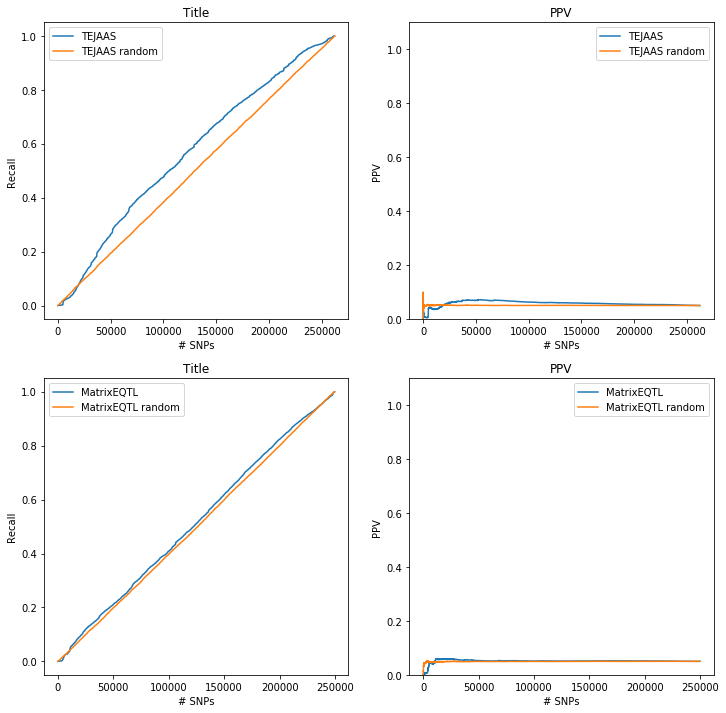

In [32]:
import matplotlib.pyplot

algorithms = ["TEJAAS" ,"MatrixEQTL"]
n_algorithms = len(algorithms)
if n_algorithms == 1:
    subplotgrid = 121
    fsize       = (12,6)
if n_algorithms == 2:
    subplotgrid = 221
    fsize       = (12,12)
if n_algorithms == 3:
    subplotgrid = 321
    fsize       = (12,18)
    
fig = plt.figure(figsize = fsize)
   
for algo_i in range(n_algorithms):
    algorithm  = algorithms[algo_i]

    if algorithm == "TEJAAS":
        test_dict, validation_dict = get_compatible_snp_dicts(tejaas_gtex_dict, tejaas_cardio_dict)
        
        if method == "rr":
#             x_vals, i_vals, n_vals, recall, ppv = evaluate_replication(test_dict, validation_dict)
#             rx_vals, ri_vals, rn_vals, rrecall, rppv = evaluate_replication(test_dict, validation_dict, randomize=True)
            x_vals, i_vals, n_vals, recall, ppv = evaluate_replication_empirical(test_dict, validation_dict)
            rx_vals, ri_vals, rn_vals, rrecall, rppv = evaluate_replication_empirical(test_dict, validation_dict, randomize=True)
        if method == "jpa":
            x_vals, i_vals, n_vals, recall, ppv = evaluate_replication_jpa(test_dict, validation_dict)
            rx_vals, ri_vals, rn_vals, rrecall, rppv = evaluate_replication_jpa(test_dict, validation_dict, randomize=True)
        
    if algorithm == "MatrixEQTL":
        validation_dict, test_dict = get_compatible_snp_dicts(mqtl_gtex_dict, mqtl_cardio_dict)
        
#         x_vals, i_vals, n_vals, recall, ppv = evaluate_replication(test_dict, validation_dict)
#         rx_vals, ri_vals, rn_vals, rrecall, rppv = evaluate_replication(test_dict, validation_dict, randomize=True)
        x_vals, i_vals, n_vals, recall, ppv = evaluate_replication_empirical(test_dict, validation_dict)
        rx_vals, ri_vals, rn_vals, rrecall, rppv = evaluate_replication_empirical(test_dict, validation_dict, randomize=True)
    
    
    ax = fig.add_subplot(subplotgrid)
    plt.title('Title')
    ax.plot(i_vals, recall, label=algorithm)
    ax.plot(ri_vals, rrecall, label=algorithm + " random")
    ax.legend()
    ax.set_xlabel("# SNPs")
    ax.set_ylabel("Recall")

    subplotgrid += 1
    ax = fig.add_subplot(subplotgrid)
    plt.title('PPV')
    ax.plot(i_vals, ppv, label=algorithm)
    ax.plot(ri_vals, rppv, label=algorithm + " random")
    ax.legend()
    ax.set_ylim(0,1.1)
    ax.set_xlabel("# SNPs")
    ax.set_ylabel("PPV")
    
    subplotgrid += 1

if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_file = os.path.join(outdir, "chr"+str(chr_list[0])+"_cardio_gtex_trans_ppv_recall.png")
print(fig_file)
# plt.savefig(fig_file)
plt.show()


In [31]:
algorithms = ["TEJAAS","MatrixEQTL"]
for algorithm in algorithms:
    if algorithm == "TEJAAS":
        get_replication_sizes(tejaas_gtex_dict, tejaas_cardio_dict, algorithm)
        
    if algorithm == "MatrixEQTL":
        get_replication_sizes(mqtl_gtex_dict, mqtl_cardio_dict, algorithm)

Algorithm      |Nº snps1|Nº snps2| common |  %   |Nº sig1 |Nº sig2 |NºC sig1|NºC sig2| common |   %  
TEJAAS         |  279091|  272252|  262206| 96.31|   72881|   28351|   66057|   25696|    7750| 27.34
Algorithm      |Nº snps1|Nº snps2| common |  %   |Nº sig1 |Nº sig2 |NºC sig1|NºC sig2| common |   %  
MatrixEQTL     |  266134|  271948|  249545| 93.77|   17080|   28073|   14212|   23963|    1566|  9.17


In [ ]:
### original

# Nº snps1|Nº snps2| common |  %   |Nº sig1 |Nº sig2 |NºC sig1|NºC sig2| common |   %  
#   279091|  272252|  262206| 96.31|   72881|   28351|   66057|   25696|    7750| 27.34
# Nº snps1|Nº snps2| common |  %   |Nº sig1 |Nº sig2 |NºC sig1|NºC sig2| common |   %  
#   277820|  271999|  260757| 95.87|   38694|   33436|   33795|   30276|   15437| 46.17



In [ ]:
tejaas_gtex_pvals = np.array(list(tejaas_gtex_dict.values())).astype(np.float64)
tejaas_cardio_pvals = np.array(list(tejaas_cardio_dict.values())).astype(np.float64)
print(min(tejaas_gtex_pvals))
print(min(tejaas_cardio_pvals))


In [ ]:
tejaas_gtex_pvals = tejaas_gtex_pvals.astype(np.float64)
tejaas_cardio_pvals.astype(np.float64)
tejaas_cardio_pvals[ tejaas_cardio_pvals == -np.inf ] = min(tejaas_cardio_pvals[ tejaas_cardio_pvals > -np.inf ])

In [ ]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
ax.hist(np.power(10, tejaas_gtex_pvals), bins=30)
ax = fig.add_subplot(122)
ax.hist(np.power(10, tejaas_cardio_pvals), bins=30)
plt.show

In [ ]:
mqtl_gtex_pvals = np.array(list(mqtl_gtex_dict.values())).astype(np.float64)
mqtl_cardio_pvals = np.array(list(mqtl_cardio_dict.values())).astype(np.float64)
# print(min(tejaas_gtex_pvals))
# print(min(tejaas_cardio_pvals))

In [ ]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
ax.hist(np.power(10, mqtl_gtex_pvals), bins=30)
ax = fig.add_subplot(122)
ax.hist(np.power(10, mqtl_cardio_pvals), bins=30)
plt.show